# Make CSD phase spike preference plot

In [1]:
import pandas as pd
import src.paths

In [88]:
DATE = '2022-09-16'
CHANNEL = 39
START = 300
END = 1500

In [89]:
%%time
path = src.paths.DATA / DATE / f'{DATE}-hpc-csd.pkl'
csd = pd.read_pickle(path)
csd = csd.loc[START:END - 1 / 1250]
csd = csd.loc[:, CHANNEL]

CPU times: user 48.1 ms, sys: 2.86 s, total: 2.91 s
Wall time: 12.7 s


---

In [90]:
%%time
path = src.paths.DATA / DATE / f'{DATE}-hpc-spikes.pkl'
spikes = pd.read_pickle(path)
spikes = spikes.loc[START:END - 1 / 250]
spikes = spikes.loc[:, range(CHANNEL * 4, CHANNEL * 4 + 4)]
spikes.columns = spikes.columns.droplevel('channel')

CPU times: user 28.4 ms, sys: 645 ms, total: 673 ms
Wall time: 2.92 s


---

In [94]:
t0 = pd.date_range(start=0, periods=len(csd), freq='0.8ms')
t = pd.date_range(start=0, periods=len(spikes), freq='4ms')
tmp = csd.copy()
tmp.index = t0
csd = tmp.reindex(t).interpolate(method='linear')
csd.index = spikes.index

---

In [96]:
UNIT = 302

In [98]:
train = spikes.index[np.where(spikes[UNIT])[0]]

---

In [264]:
import pywt

In [666]:
FREQ_MIN = 4
FREQ_MAX = 80
WAVELET = pywt.ContinuousWavelet('cmor1.5-1.0')

In [700]:
freqs = np.logspace(np.log10(FREQ_MIN), np.log10(FREQ_MAX), 40)
freqs = pd.Series(freqs, name='frequency')

In [701]:
%%time
T = 1 / 250
scales = pywt.frequency2scale(WAVELET, freqs * T)
coef, outfreqs = pywt.cwt(csd, scales, WAVELET, sampling_period=T)

CPU times: user 1.18 s, sys: 0 ns, total: 1.18 s
Wall time: 1.17 s


In [702]:
phase = np.angle(coef)
phase = pd.DataFrame(phase.T, index=csd.index, columns=freqs)

---

In [703]:
l = []
for f in freqs:
    bins = np.linspace(-np.pi, np.pi, 20)
    counts, outbins = np.histogram(phase[f][spikes[UNIT].astype('bool')], bins=bins)
    l.append(counts)

In [704]:
bins = pd.Series(bins[:-1], name='phase')
hist = pd.DataFrame(np.array(l), index=freqs, columns=bins)

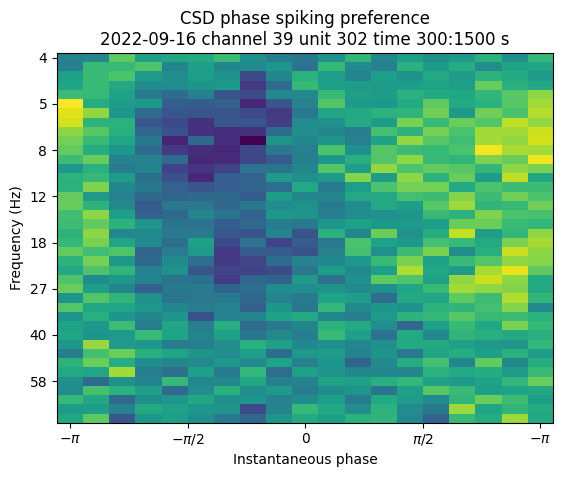

In [748]:
plt.title(f'CSD phase spiking preference\n{DATE} channel {CHANNEL} unit {UNIT} time {START}:{END} s')
plt.gca().matshow(hist.values, interpolation='none')
plt.axis('auto')
plt.yticks(np.arange(hist.shape[0])[::5], freqs.astype('int')[::5])
plt.xticks(np.arange(5) / 4 * (hist.shape[1] - 1), ['$-\pi$', '$-\pi/2$', 0, '$\pi/2$', '$-\pi$'])
plt.tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False)
plt.xlabel('Instantaneous phase')
plt.ylabel('Frequency (Hz)')
plt.savefig(f'{DATE}-phase-spike-hist-channel-{CHANNEL}-unit-{UNIT}-time-{START}-{END}', dpi=300)
plt.show()